In [472]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [473]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jul 16 21:18:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    40W / 250W |    453MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [474]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [475]:
#importing libraries
import pandas as pd
import seaborn as sns
#from io import StringIO
#import requests
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # used for encoding categorical data
from sklearn.preprocessing import StandardScaler # used for feature scaling
from sklearn.metrics import log_loss
from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
# for encoding using feature-engine
#import feature_engine.categorical_encoders
import numpy as n
import random
import pandas as pd
import copy
import time
import matplotlib.pyplot as plt

### EDA & Feature Engineering

The training set contains over 3.7 million records, we will read 10000 lines from training dataset to train easily



In [476]:
try:
    df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/training_data.csv", delimiter=";",nrows=10000)
    print(" dataset has {} samples with {} features each.".format(*df.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

 dataset has 10000 samples with 17 features each.


In [477]:
df.head()

,id,timestamp,campaignId,platform,softwareVersion,sourceGameId,country,startCount,viewCount,clickCount,installCount,lastStart,startCount1d,startCount7d,connectionType,deviceType,install
0,5c36658fb58fad351175f0b6,2019-01-09T21:20:15.943+00:00,59687f0d896a6b0e5ce6ea15,ios,11.4.1,1373094,US,25,24,0,2,2019-01-08T18:49:48.129+00:00,1,8,cellular,"iPhone8,2",0
1,5c38d5ab1c16172870186b5a,2019-01-11T17:43:07.609+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1,2739989,US,10,9,2,0,2019-01-09T21:20:22.855+00:00,1,4,cellular,"iPhone9,1",0
2,5c38815de8f4e50e256e4f9c,2019-01-11T11:43:25.168+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1373094,US,27,26,0,0,2019-01-09T10:42:08.446+00:00,1,2,cellular,"iPhone7,1",0
3,5c409ace532d5806d2c6a5e6,2019-01-17T15:10:06.420+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1217749,US,15,14,2,0,2019-01-16T19:58:11.636+00:00,3,14,wifi,"iPhone7,2",0
4,5c3904b92d798c41e7f3088a,2019-01-11T21:03:53.145+00:00,59687f0d896a6b0e5ce6ea15,ios,12.0.1,1373094,US,20,18,0,0,2019-01-11T21:03:05.103+00:00,13,18,cellular,"iPhone8,1",0


### Features Engineering

In [478]:
df['day'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True).dt.day
df['hour'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True).dt.hour
df['month'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True).dt.month
df['weekday_name'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True).dt.day_name()


In [479]:
df.head()

,id,timestamp,campaignId,platform,softwareVersion,sourceGameId,country,startCount,viewCount,clickCount,installCount,lastStart,startCount1d,startCount7d,connectionType,deviceType,install,day,hour,month,weekday_name
0,5c36658fb58fad351175f0b6,2019-01-09T21:20:15.943+00:00,59687f0d896a6b0e5ce6ea15,ios,11.4.1,1373094,US,25,24,0,2,2019-01-08T18:49:48.129+00:00,1,8,cellular,"iPhone8,2",0,9,21,1,Wednesday
1,5c38d5ab1c16172870186b5a,2019-01-11T17:43:07.609+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1,2739989,US,10,9,2,0,2019-01-09T21:20:22.855+00:00,1,4,cellular,"iPhone9,1",0,11,17,1,Friday
2,5c38815de8f4e50e256e4f9c,2019-01-11T11:43:25.168+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1373094,US,27,26,0,0,2019-01-09T10:42:08.446+00:00,1,2,cellular,"iPhone7,1",0,11,11,1,Friday
3,5c409ace532d5806d2c6a5e6,2019-01-17T15:10:06.420+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1217749,US,15,14,2,0,2019-01-16T19:58:11.636+00:00,3,14,wifi,"iPhone7,2",0,17,15,1,Thursday
4,5c3904b92d798c41e7f3088a,2019-01-11T21:03:53.145+00:00,59687f0d896a6b0e5ce6ea15,ios,12.0.1,1373094,US,20,18,0,0,2019-01-11T21:03:05.103+00:00,13,18,cellular,"iPhone8,1",0,11,21,1,Friday


In [480]:
result = df.deviceType.str.extract('([a-zA-Z]+)([^a-zA-Z]+)', expand=True)
result.columns = ['device_Type', 'device_model']
result.head()

,device_Type,device_model
0,iPhone,"8,2"
1,iPhone,"9,1"
2,iPhone,"7,1"
3,iPhone,"7,2"
4,iPhone,"8,1"


In [481]:
data = pd.concat([df, result], axis=1, sort=False)
data.head()

,id,timestamp,campaignId,platform,softwareVersion,sourceGameId,country,startCount,viewCount,clickCount,installCount,lastStart,startCount1d,startCount7d,connectionType,deviceType,install,day,hour,month,weekday_name,device_Type,device_model
0,5c36658fb58fad351175f0b6,2019-01-09T21:20:15.943+00:00,59687f0d896a6b0e5ce6ea15,ios,11.4.1,1373094,US,25,24,0,2,2019-01-08T18:49:48.129+00:00,1,8,cellular,"iPhone8,2",0,9,21,1,Wednesday,iPhone,"8,2"
1,5c38d5ab1c16172870186b5a,2019-01-11T17:43:07.609+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1,2739989,US,10,9,2,0,2019-01-09T21:20:22.855+00:00,1,4,cellular,"iPhone9,1",0,11,17,1,Friday,iPhone,"9,1"
2,5c38815de8f4e50e256e4f9c,2019-01-11T11:43:25.168+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1373094,US,27,26,0,0,2019-01-09T10:42:08.446+00:00,1,2,cellular,"iPhone7,1",0,11,11,1,Friday,iPhone,"7,1"
3,5c409ace532d5806d2c6a5e6,2019-01-17T15:10:06.420+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1217749,US,15,14,2,0,2019-01-16T19:58:11.636+00:00,3,14,wifi,"iPhone7,2",0,17,15,1,Thursday,iPhone,"7,2"
4,5c3904b92d798c41e7f3088a,2019-01-11T21:03:53.145+00:00,59687f0d896a6b0e5ce6ea15,ios,12.0.1,1373094,US,20,18,0,0,2019-01-11T21:03:05.103+00:00,13,18,cellular,"iPhone8,1",0,11,21,1,Friday,iPhone,"8,1"


We can group all the features in the data into the following categories:
        
        Target feature : install
        app feature: platform	softwareVersion	sourceGameId
        device feature: device_model, device_Type, connectionType

To check the NaN values in data set,we will use heat maps

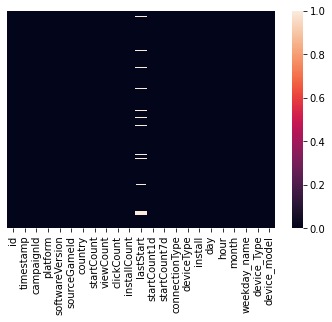

In [482]:
sns.heatmap(data.isna(), yticklabels=False, cbar=True)

In [483]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               10000 non-null  object
 1   timestamp        10000 non-null  object
 2   campaignId       10000 non-null  object
 3   platform         10000 non-null  object
 4   softwareVersion  10000 non-null  object
 5   sourceGameId     10000 non-null  int64 
 6   country          10000 non-null  object
 7   startCount       10000 non-null  int64 
 8   viewCount        10000 non-null  int64 
 9   clickCount       10000 non-null  int64 
 10  installCount     10000 non-null  int64 
 11  lastStart        9345 non-null   object
 12  startCount1d     10000 non-null  int64 
 13  startCount7d     10000 non-null  int64 
 14  connectionType   10000 non-null  object
 15  deviceType       10000 non-null  object
 16  install          10000 non-null  int64 
 17  day              10000 non-null 

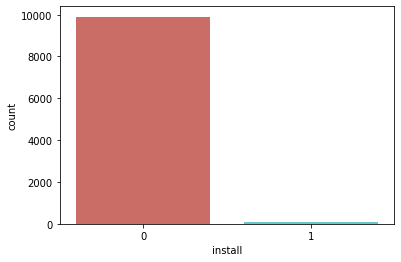

In [484]:
del data["deviceType"]
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='install',data=data, palette='hls')
plt.show();

In [485]:
data['install'].value_counts()/len(data)

0    0.9902
1    0.0098
Name: install, dtype: float64

The overall install rate is approx. 1%, and approx. 99% is not installed.

The data covers 14 days of click streams data, that is 336 hours.

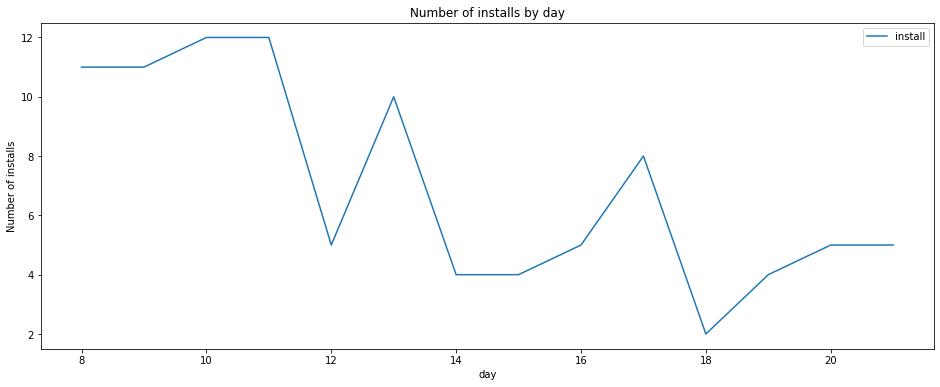

In [486]:
data.groupby('day').agg({'install':'sum'}).plot(figsize=(16,6))
plt.ylabel('Number of installs')
plt.title('Number of installs by day');

On complete data It appears that the most intallations take place on day 8,9 and again 19, 20. However, it maximizes on 8,9 day. But using 10000 rows, it appears max installations take place on 8,9 hour

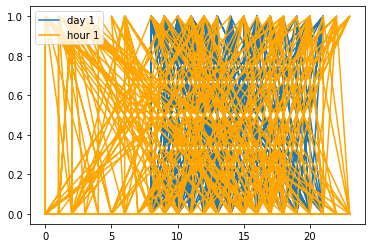

In [487]:
#Moving averages for day and Hour

rolling_mean = data.install.rolling(window=1).mean()
rolling_mean2 = data.install.rolling(window=24).mean()
plt.plot(data.day, data.install, label='day 1')
plt.plot(data.hour, rolling_mean, label='hour 1', color='orange')
#plt.plot(df.ds, rolling_mean2, label='AMD 50 Day SMA', color='magenta')
plt.legend(loc='upper left')
plt.show()

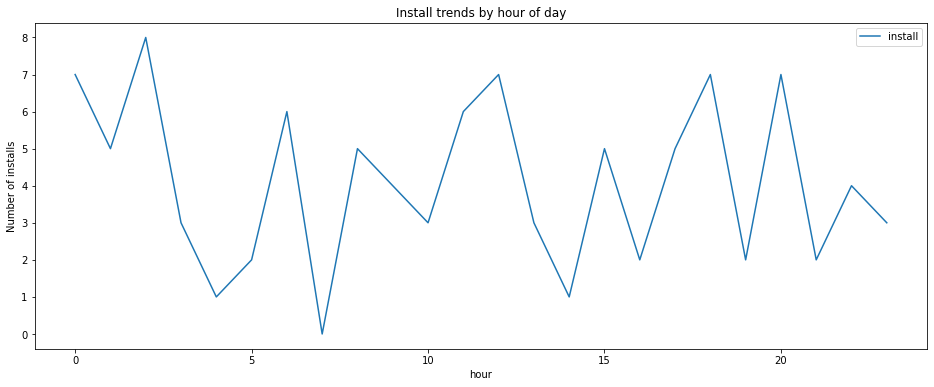

In [488]:
data.groupby('hour').agg({'install':'sum'}).plot(figsize=(16,6))
plt.ylabel('Number of installs')
plt.title('Install trends by hour of day');

The Complete data shows that installations occur mostly at 12 to 2o clock. Noon is the time for highest activity, However with 10000 rows it shows around 2-3 o clock peak in the morning

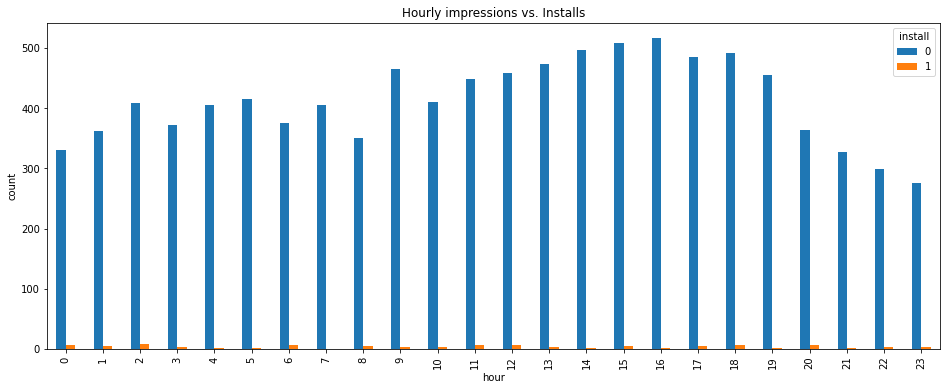

In [489]:
data.groupby(['hour', 'install']).size().unstack().plot(kind='bar', title="Hour of Day", figsize=(16,6))
plt.ylabel('count')
plt.title('Hourly impressions vs. Installs');

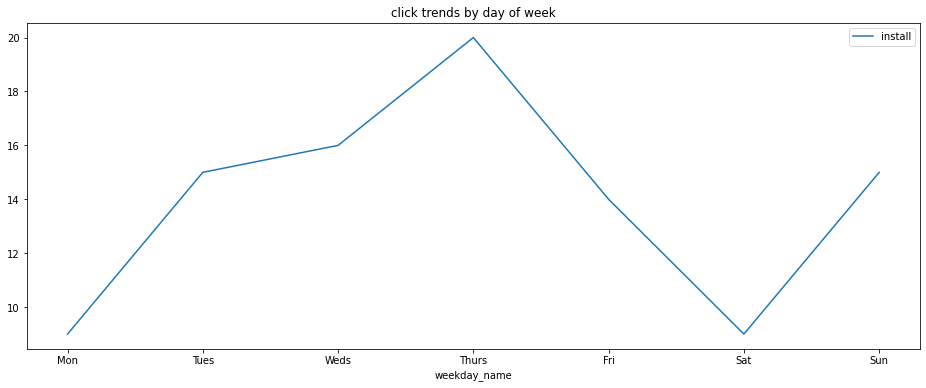

In [490]:
#data['day_of_week'] = data['hour'].apply(lambda val: val.weekday_name)
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data.groupby('weekday_name').agg({'install':'sum'}).reindex(cats).plot(figsize=(16,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('click trends by day of week');

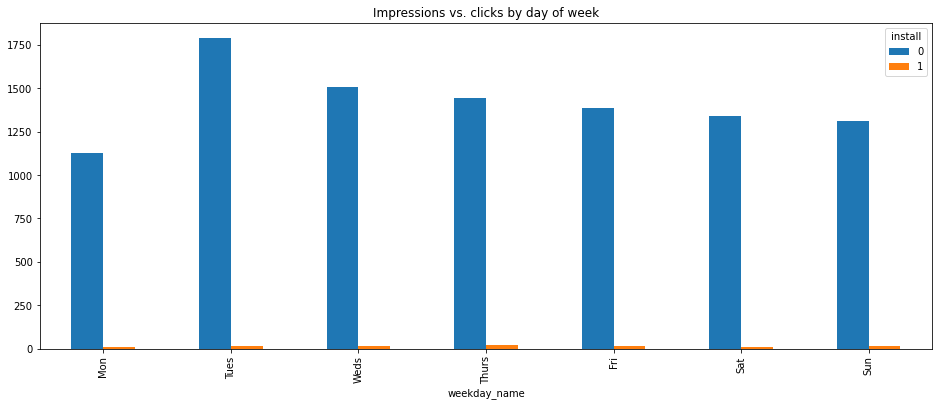

In [491]:
data.groupby(['weekday_name','install']).size().unstack().reindex(cats).plot(kind='bar', title="Day of the Week", figsize=(16,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('Impressions vs. clicks by day of week');

In [492]:
print('The top 10 campaignId that have the most impressions')
print((data.campaignId.value_counts()/len(data))[0:10])



The top 10 campaignId that have the most impressions
5ba4a3c11e78b0013ccbf626    0.2334
5b71383cce516401e6622693    0.1563
5afc25a3e9d7d501c8039533    0.0775
5c181fdf16b0db0015eaf773    0.0697
5c18adb6d26b2000590f1084    0.0532
5b4d8496cba76d1e6a434858    0.0428
5b95e5852924ee4a52c55b04    0.0377
5be298df7af4bf81a8e94b38    0.0364
5c1a0870eda61c05a85a8cbf    0.0305
5c257060da33aeebbebf1b03    0.0279
Name: campaignId, dtype: float64


In [493]:
"""
data.groupby(['campaignId', 'install']).size().unstack().plot(kind='bar', title="campaignId vs. Installs", figsize=(16,6))
plt.ylabel('count')
plt.title('campaignId vs. Installs');

"""

'\ndata.groupby([\'campaignId\', \'install\']).size().unstack().plot(kind=\'bar\', title="campaignId vs. Installs", figsize=(16,6))\nplt.ylabel(\'count\')\nplt.title(\'campaignId vs. Installs\');\n\n'

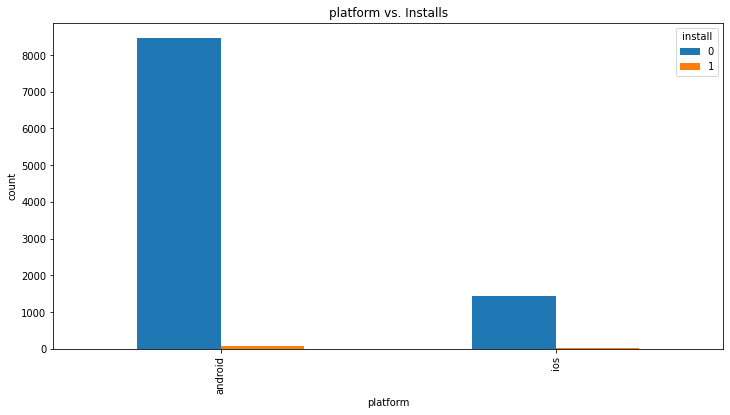

In [494]:
data.groupby(['platform', 'install']).size().unstack().plot(kind='bar', title="platform vs. Installs", figsize=(12,6))
plt.ylabel('count')
plt.title('platform vs. Installs');



In [495]:
print('The top 10 sourceGameId that have the most impressions')
print((data.sourceGameId.value_counts()/len(data))[0:10])


The top 10 sourceGameId that have the most impressions
2249178    0.0182
1644775    0.0168
1566453    0.0147
79447      0.0119
55574      0.0114
1742668    0.0095
1432611    0.0092
1851135    0.0085
1371999    0.0076
1708734    0.0076
Name: sourceGameId, dtype: float64


In [496]:
sum(data.sourceGameId.value_counts()>=100)

5

In [497]:
sum(data.sourceGameId.value_counts()>=50)

23

In [498]:
sum(data.sourceGameId.value_counts()==1)

1551

In [499]:
"""data.groupby(['country', 'install']).size().unstack().plot(kind='bar', title="country vs. Installs", figsize=(16,6))
plt.ylabel('count')
plt.title('country vs. Installs');
"""

print('The top 10 countries that have the most impressions')
print((data.country.value_counts()/len(data))[0:10])

The top 10 countries that have the most impressions
RU    0.3927
US    0.2111
CN    0.0858
AU    0.0585
IN    0.0424
GB    0.0296
UA    0.0232
IT    0.0218
CA    0.0216
TW    0.0162
Name: country, dtype: float64


In [500]:
print('The top 10 device_Type that have the most impressions')
print((data.device_Type.value_counts()/len(data))[0:10])


The top 10 device_Type that have the most impressions
samsung     0.3286
HUAWEI      0.1210
iPhone      0.1101
Xiaomi      0.0934
iPad        0.0369
LGE         0.0358
OPPO        0.0225
motorola    0.0209
LENOVO      0.0189
vivo        0.0181
Name: device_Type, dtype: float64


In [501]:
data.columns

Index(['id', 'timestamp', 'campaignId', 'platform', 'softwareVersion',
       'sourceGameId', 'country', 'startCount', 'viewCount', 'clickCount',
       'installCount', 'lastStart', 'startCount1d', 'startCount7d',
       'connectionType', 'install', 'day', 'hour', 'month', 'weekday_name',
       'device_Type', 'device_model'],
      dtype='object')

In [502]:
data = data[[c for c in data if c not in ['install']] 
       + ['install']]
data.head()

,id,timestamp,campaignId,platform,softwareVersion,sourceGameId,country,startCount,viewCount,clickCount,installCount,lastStart,startCount1d,startCount7d,connectionType,day,hour,month,weekday_name,device_Type,device_model,install
0,5c36658fb58fad351175f0b6,2019-01-09T21:20:15.943+00:00,59687f0d896a6b0e5ce6ea15,ios,11.4.1,1373094,US,25,24,0,2,2019-01-08T18:49:48.129+00:00,1,8,cellular,9,21,1,Wednesday,iPhone,"8,2",0
1,5c38d5ab1c16172870186b5a,2019-01-11T17:43:07.609+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1,2739989,US,10,9,2,0,2019-01-09T21:20:22.855+00:00,1,4,cellular,11,17,1,Friday,iPhone,"9,1",0
2,5c38815de8f4e50e256e4f9c,2019-01-11T11:43:25.168+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1373094,US,27,26,0,0,2019-01-09T10:42:08.446+00:00,1,2,cellular,11,11,1,Friday,iPhone,"7,1",0
3,5c409ace532d5806d2c6a5e6,2019-01-17T15:10:06.420+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1217749,US,15,14,2,0,2019-01-16T19:58:11.636+00:00,3,14,wifi,17,15,1,Thursday,iPhone,"7,2",0
4,5c3904b92d798c41e7f3088a,2019-01-11T21:03:53.145+00:00,59687f0d896a6b0e5ce6ea15,ios,12.0.1,1373094,US,20,18,0,0,2019-01-11T21:03:05.103+00:00,13,18,cellular,11,21,1,Friday,iPhone,"8,1",0


In [503]:
data.columns.size

22

A hash function is a function that maps a set of objects to a set of integers. When using a hash function, this mapping is performed which takes a key of arbitrary length as input and outputs an integer in a specific range.
purposes of the hashing is to minimize memory consumption by the features. Python has a built in function that performs a hash called hash()

In [504]:
def convert_obj_to_int(self):
    
    object_list_columns = self.columns
    object_list_dtypes = self.dtypes
    new_col_suffix = '_int'
    for index in range(0,len(object_list_columns)):
        if object_list_dtypes[index] == object :
            self[object_list_columns[index]+new_col_suffix] = self[object_list_columns[index]].map( lambda  x: hash(x))
            self.drop([object_list_columns[index]],inplace=True,axis=1)
    return self
data = convert_obj_to_int(data)

In [505]:
# Binary Classification with Sonar Dataset: Baseline
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

since this is a hishly imbalanced dataset we can employ stratified sampling technique 

In [506]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 10, test_size = 0.3, random_state = 42)

for training_indices, testing_indices in split.split(data, data["install"]):
        stratified_training_data = data.loc[training_indices]
        stratified_testing_data = data.loc[testing_indices]

In [507]:
stratified_training_data.shape, stratified_testing_data.shape


((7000, 22), (3000, 22))

In [508]:
print(data["install"].value_counts()/len(data))

print(stratified_training_data["install"].value_counts()/len(stratified_training_data))
print(stratified_testing_data["install"].value_counts()/len(stratified_testing_data))

0    0.9902
1    0.0098
Name: install, dtype: float64
0    0.990143
1    0.009857
Name: install, dtype: float64
0    0.990333
1    0.009667
Name: install, dtype: float64


In [509]:
count_class_0, count_class_1 = stratified_training_data.install.value_counts()

df_class_0 = stratified_training_data[stratified_training_data['install'] == 0]
df_class_1 = stratified_training_data[stratified_training_data['install'] == 1]

Random over-sampling:
1    6931
0    6931
Name: install, dtype: int64


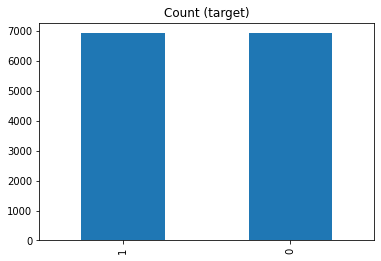

In [510]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.install.value_counts())

df_test_over.install.value_counts().plot(kind='bar', title='Count (target)');

In [511]:
cols = list(df_test_over.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('install')) #Remove b from list
X_train = df_test_over[cols]
X_train.shape

(13862, 21)

In [512]:
y_train = df_test_over["install"]
y_train.shape

(13862,)

In [513]:
cols = list(stratified_testing_data.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('install')) #Remove b from list
X_test = stratified_testing_data[cols]
X_test.shape

(3000, 21)

In [514]:
y_test = stratified_testing_data["install"]
y_test.shape

(3000,)

In [515]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X_train)
X_train_minmax = min_max_scaler.transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)

**Modelling approach**

In [516]:
#from tensorflow.keras.callbacks import TensorBoard
import tensorflow
NAME = "MODEL-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

from keras.callbacks import TensorBoard

The below code creates a Neural Network that has with multiple layers. The best model will be selected. The last node uses the sigmoid activation function that will squeeze all the values between 0 and 1 into the form of a sigmoid curve. The other layers use ReLU (Rectified Linear Units) as the activation function. ReLU is a half rectified function; that is, for all the inputs less than 0 (e.g. -120,-6.7, -0.0344, 0) the value is 0 while for anything positive (e.g. 10,15, 34) the value is retained. One output unit is used since for each record values in X, a probability will be predicted.

In [517]:
dense_layers = [2,3,4,5]
layer_sizes = [16,32,64]
#conv_layers = [4, 5]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        NAME = "{}-nodes-{}-dense-{}".format(layer_size, dense_layer, int(time.time()))
        print(NAME)

        model = Sequential()
        #model = tensorflow.keras.Sequential()
        #model.add(vgg_model.layers[0])
        model.add(Dense(layer_size, activation='relu', input_shape=(21,)))
        #model.add(Activation('relu'))


        #model.add(Flatten())

        for _ in range(dense_layer):
            model.add(Dense(layer_size, activation='relu'))
            #model.add(Dense(layer_size))
            #model.add(Activation('relu'))
            #model.add(Dropout(0.2))

        model.add(Dense(1, activation='sigmoid'))        
  #      model.add(Dense(1))
  #      model.add(Activation('sigmoid'))

        tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
        model.summary()
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'],
                      )

        model.fit(X_train, y_train,epochs=20, validation_split=0.1, batch_size=32, verbose=1, callbacks=[tensorboard])


16-nodes-2-dense-1594934303
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_192 (Dense)            (None, 16)                352       
_________________________________________________________________
dense_193 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_194 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_195 (Dense)            (None, 1)                 17        
Total params: 913
Trainable params: 913
Non-trainable params: 0
_________________________________________________________________
Train on 12475 samples, validate on 1387 samples
Epoch 1/20
12475/12475 [==============================] - 2s 136us/step - loss: 81543713236055424.0000 - accuracy: 0.6355 - val_loss: 1850546332277041.7500 - val_accuracy: 0.87

Tensorboard : TensorFlow's visualization toolkit
Go to cmd and type the following commands

tensorboard --logdir='logs/'
Copy the link and paste on browser to see the visualizations
Go to http://localhost:6006/

since the occam razor proinciple states that the simplest model is the best model so the max validation accuracy as shown in tensorboard is also visible with this model, I will save the following model and test my model performance on the test dataset


In [523]:
model.save("16-nodes-2-dense-1594934303")

In [528]:
model = tf.keras.models.load_model("/content/16-nodes-2-dense-1594934303")

**Performance evaluation of the model**

In [529]:
y_pred = model.predict(X_test)
score = model.evaluate(X_test, y_test,verbose=1)

print(score)

94/94 [==============================] - 0s 2ms/step - loss: 141463673372672.0000 - accuracy: 0.9567
[141463673372672.0, 0.9566666483879089]


In [530]:
# Import the modules from `sklearn.metrics`
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score#, cohen_kappa_score

# Confusion matrix
confusion_matrix(y_test, y_pred.round())

array([[2869,  102],
       [  28,    1]])

In [531]:
# Precision 
precision_score(y_test, y_pred.round())

0.009708737864077669

In [532]:
# Recall
recall_score(y_test, y_pred.round())

0.034482758620689655

In [533]:
# F1 score
f1_score(y_test,y_pred.round())

0.015151515151515152

Let's resress on test dataset

In [534]:
#import sklearn
#sklearn.metrics.log_loss(y_test, y_pred)#.round()



In [535]:
from sklearn.metrics import roc_auc_score
probs = model.predict_proba(X_test)
# keep the predictions for class 1 only
#probs = probs[:, 1]
# calculate log loss
loss = roc_auc_score(y_test, probs)
loss

Instructions for updating:
Please use `model.predict()` instead.


0.5239499065680893

In [536]:
probs

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

read test file and perform same tasks performed on test dataset

In [537]:
try:
    df_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/test_data.csv", delimiter=";")#),nrows=10000)
    print(" dataset has {} samples with {} features each.".format(*df_test.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")
   

 dataset has 3739968 samples with 16 features each.


In [538]:
df_test.head()

,id,timestamp,campaignId,platform,softwareVersion,sourceGameId,country,startCount,viewCount,clickCount,installCount,lastStart,startCount1d,startCount7d,connectionType,deviceType
0,5c4609b6eb7476266130c224,2019-01-21T18:04:38.028+00:00,598c1d93ca9cf7103cf61dcc,android,4.4.2,1515907,RU,6,5,0,0,2019-01-21T17:58:23.728+00:00,6,6,wifi,LENOVO Lenovo A536
1,5c454de3a21d3edde84568d9,2019-01-21T04:43:15.681+00:00,598c1d93ca9cf7103cf61dcc,android,5.1,2724746,MY,1,0,0,1,NaN,1,1,cellular,HUAWEI HUAWEI LUA-U22
2,5c3c4f5769db2eee0c345059,2019-01-14T08:59:03.489+00:00,598c1d93ca9cf7103cf61dcc,android,4.4.4,78130,TR,49,29,4,1,2019-01-14T08:56:10.539+00:00,4,17,wifi,samsung SM-T113
3,5c4476bdf81acd685863a34f,2019-01-20T13:25:17.556+00:00,598c1d93ca9cf7103cf61dcc,android,4.4.4,1261034,TR,1,0,0,1,NaN,1,1,wifi,samsung SM-T113
4,5c456954b7d257ead2f99568,2019-01-21T06:40:20.962+00:00,598c1d93ca9cf7103cf61dcc,android,5.1,1617990,MY,7,4,0,1,2019-01-21T06:38:38.298+00:00,3,7,cellular,OPPO X9009


In [539]:
df_test['day'] = pd.to_datetime(df_test['timestamp'], infer_datetime_format=True).dt.day
df_test['hour'] = pd.to_datetime(df_test['timestamp'], infer_datetime_format=True).dt.hour
df_test['month'] = pd.to_datetime(df_test['timestamp'], infer_datetime_format=True).dt.month
df_test['weekday_name'] = pd.to_datetime(df_test['timestamp'], infer_datetime_format=True).dt.day_name()

In [540]:
result = df_test.deviceType.str.extract('([a-zA-Z]+)([^a-zA-Z]+)', expand=True)
result.columns = ['device_Type', 'device_model']
result.head()

,device_Type,device_model
0,LENOVO,
1,HUAWEI,
2,samsung,
3,samsung,
4,OPPO,


In [541]:
data_test = pd.concat([df_test, result], axis=1, sort=False)
del data_test["deviceType"]
data_test.head()

,id,timestamp,campaignId,platform,softwareVersion,sourceGameId,country,startCount,viewCount,clickCount,installCount,lastStart,startCount1d,startCount7d,connectionType,day,hour,month,weekday_name,device_Type,device_model
0,5c4609b6eb7476266130c224,2019-01-21T18:04:38.028+00:00,598c1d93ca9cf7103cf61dcc,android,4.4.2,1515907,RU,6,5,0,0,2019-01-21T17:58:23.728+00:00,6,6,wifi,21,18,1,Monday,LENOVO,
1,5c454de3a21d3edde84568d9,2019-01-21T04:43:15.681+00:00,598c1d93ca9cf7103cf61dcc,android,5.1,2724746,MY,1,0,0,1,NaN,1,1,cellular,21,4,1,Monday,HUAWEI,
2,5c3c4f5769db2eee0c345059,2019-01-14T08:59:03.489+00:00,598c1d93ca9cf7103cf61dcc,android,4.4.4,78130,TR,49,29,4,1,2019-01-14T08:56:10.539+00:00,4,17,wifi,14,8,1,Monday,samsung,
3,5c4476bdf81acd685863a34f,2019-01-20T13:25:17.556+00:00,598c1d93ca9cf7103cf61dcc,android,4.4.4,1261034,TR,1,0,0,1,NaN,1,1,wifi,20,13,1,Sunday,samsung,
4,5c456954b7d257ead2f99568,2019-01-21T06:40:20.962+00:00,598c1d93ca9cf7103cf61dcc,android,5.1,1617990,MY,7,4,0,1,2019-01-21T06:38:38.298+00:00,3,7,cellular,21,6,1,Monday,OPPO,


In [542]:
 
data_test = convert_obj_to_int(data_test)    
data_test_minmax = min_max_scaler.transform(data_test)
from sklearn.metrics import roc_auc_score
test_probs = model.predict_proba(data_test_minmax)
test_probs.view()

array([[0.43489745],
       [0.43504214],
       [0.4350618 ],
       ...,
       [0.43510985],
       [0.43504477],
       [0.4352241 ]], dtype=float32)

In [543]:
test_probs.size

3739968

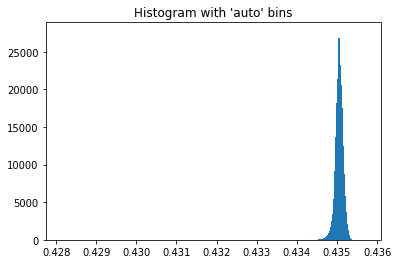

In [544]:
#np.histogram(test_probs, bins=10, range=None, normed=None, weights=None, density=None)
import numpy as np

a = np.hstack(test_probs)
plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
#Text(0.5, 1.0, "Histogram with 'auto' bins")
plt.show()


In [545]:
dataframe=pd.DataFrame(test_probs, columns=['install_proba']) 
final_prob = pd.concat([df_test["id"], dataframe], axis=1, sort=False)
final_prob.head()

,id,install_proba
0,5c4609b6eb7476266130c224,0.434897
1,5c454de3a21d3edde84568d9,0.435042
2,5c3c4f5769db2eee0c345059,0.435062
3,5c4476bdf81acd685863a34f,0.435163
4,5c456954b7d257ead2f99568,0.435025


In [546]:
#import pickle
#final_prob.to_pickle("install_proba.pkl")

final_prob.to_csv("install_probaility", sep='\t', index=False, encoding='utf-8')

### Feature Importance via Gradient Boosting

Start training...
[10]	valid_0's l2: 0.00761177	valid_0's binary_logloss: 0.045727
[20]	valid_0's l2: 0.00753652	valid_0's binary_logloss: 0.0458792
[30]	valid_0's l2: 0.0076764	valid_0's binary_logloss: 0.0470615
[40]	valid_0's l2: 0.00747995	valid_0's binary_logloss: 0.0457043
[50]	valid_0's l2: 0.00755237	valid_0's binary_logloss: 0.0478194
[60]	valid_0's l2: 0.0078635	valid_0's binary_logloss: 0.0501898
[70]	valid_0's l2: 0.0076595	valid_0's binary_logloss: 0.0516074
[80]	valid_0's l2: 0.00761141	valid_0's binary_logloss: 0.0530567
[90]	valid_0's l2: 0.00752204	valid_0's binary_logloss: 0.055408
[100]	valid_0's l2: 0.00745718	valid_0's binary_logloss: 0.0573439
[110]	valid_0's l2: 0.00740986	valid_0's binary_logloss: 0.0610248
[120]	valid_0's l2: 0.00741355	valid_0's binary_logloss: 0.0633592
[130]	valid_0's l2: 0.00995535	valid_0's binary_logloss: 0.102525
[140]	valid_0's l2: 0.0220045	valid_0's binary_logloss: 0.359734
[150]	valid_0's l2: 0.0348586	valid_0's binary_logloss: 0.897

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: more than one metric available, picking one to plot.


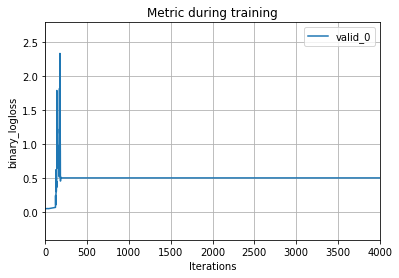

In [547]:
import lightgbm as lgb
import numpy as np

X_train = data.loc[:, data.columns != 'install']
y_target = data.install.values
#create lightgbm dataset
msk = np.random.rand(len(X_train)) < 0.8
lgb_train = lgb.Dataset(X_train[msk], y_target[msk])
lgb_eval = lgb.Dataset(X_train[~msk], y_target[~msk], reference=lgb_train)

# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': { 'mse', 'binary_logloss' },
    'num_leaves': 31, # defauly leaves(31) amount for each tree
    'learning_rate': 0.08,
    'feature_fraction': 0.7, # will select 70% features before training each tree
    'bagging_fraction': 0.3, #feature_fraction, but this will random select part of data
    'bagging_freq': 5, #  perform bagging at every 5 iteration
    'verbose': 0
}

evals_result = {}  # to record eval results for plotting

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=4000,
                valid_sets=lgb_eval,
                #feature_name=['f' + str(i + 1) for i in range(28)],
                #categorical_feature=[21],
                evals_result=evals_result,
                #early_stopping_rounds=5000,
               # metric='mse',
                verbose_eval=10)

print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result)#, metric='mse')
plt.show()

Plot feature importances...


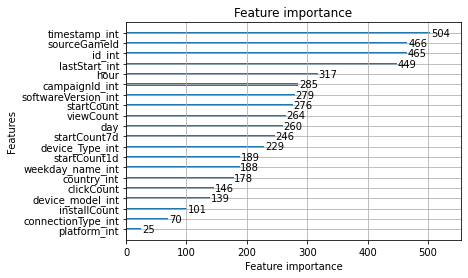

Plot 300th tree...


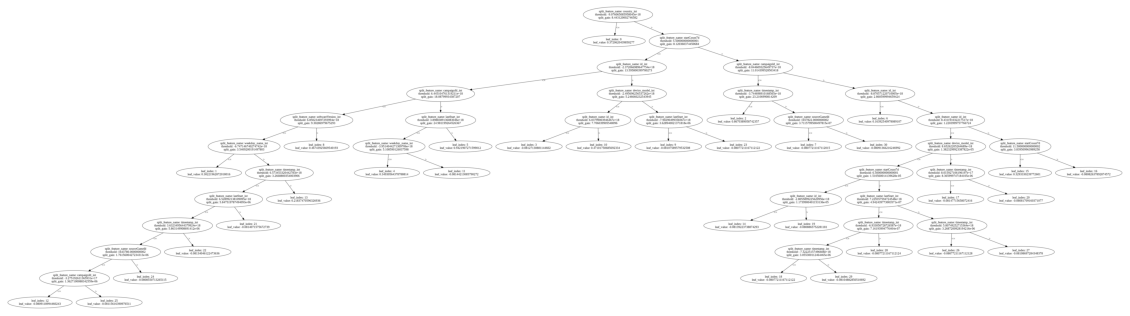

Plot 300th tree with graphviz...


'Tree300.gv.pdf'

In [548]:
print('Plot feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=20)
plt.show()

print('Plot 300th tree...')  # one tree use categorical feature to split
ax = lgb.plot_tree(gbm, tree_index=1, figsize=(20, 15), show_info=['split_gain'])
plt.show()

print('Plot 300th tree with graphviz...')
graph = lgb.create_tree_digraph(gbm, tree_index=1, name='Tree300')
graph.render(view=True)

### Future Works

A sophisticated deep learning model can be used (transfer learning) or reinforcement learning can be employed which is also used for real-time bidding.